In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# 데이터 불러오기 및 전처리
data_row=pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0426/train/sentence 1/train_data_after_vector.csv",index_col=0)
y_train = pd.get_dummies(data_row['predict']).values
X_train = data_row.drop(columns=['predict']).values

test = pd.read_csv("/Users/withmocha/Desktop/DATA/Capston Design(2024)/data(sentence)/0426/test/sentence 1/test_data_after_vector.csv", index_col=0)
test_y = pd.get_dummies(test['predict']).values
test_x = test.drop(columns=['predict']).values

In [3]:
# PyTorch Tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float).unsqueeze(1)
y_train = torch.tensor(y_train, dtype=torch.float)
test_x = torch.tensor(test_x, dtype=torch.float).unsqueeze(1)
test_y = torch.tensor(test_y, dtype=torch.float)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([20323, 1, 768])
torch.Size([20323, 3])
torch.Size([298, 1, 768])
torch.Size([298, 3])


In [5]:
# DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=400, shuffle=True)

test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, shuffle=False)

In [6]:
class Fishing_Detection(nn.Module):
    def __init__(self):
        super(Fishing_Detection, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=128, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(128)  # 배치 정규화 추가
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(64)  # 배치 정규화 추가
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=1)
        self.bn3 = nn.BatchNorm1d(32)  # 배치 정규화 추가
        self.pool = nn.MaxPool1d(kernel_size=1)
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(input_size=32, hidden_size=128, num_layers=2, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(128*2, 32)
        self.fc2 = nn.Linear(32, 3)
        self.activation = nn.ELU()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.activation(self.bn2(self.conv2(x)))
        x = self.activation(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


model = Fishing_Detection()

In [7]:
import math
import torch
from torch.optim.optimizer import Optimizer

class PADAM(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, partial=1/4):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, partial=partial)
        super(PADAM, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('PADAM does not support sparse gradients')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(p.data, alpha=group['weight_decay'])

                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1-beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                step_size = group['lr'] * math.pow(state['step'], -group['partial'])

                p.data.addcdiv_(exp_avg, denom, value=-step_size)

        return loss


In [8]:
# 손실 함수 및 최적화 알고리즘 설정
from adamp import AdamP
#from keras_radam import RAdam
criterion = nn.CrossEntropyLoss()
optimizer = PADAM(model.parameters(), lr=0.003, weight_decay=1e-5)

In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt


In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

 
# 스케쥴러 정의
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5, verbose=True)

num_epochs = 200
training_losses = []
validation_losses = []

patience = 30
counter = 0
best_loss = None

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            validation_loss += loss.item()
    
    avg_validation_loss = validation_loss / len(test_loader)
    validation_losses.append(avg_validation_loss)

    print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss}, Validation Loss: {avg_validation_loss}')
    
    # 스케쥴러 단계
    scheduler.step(avg_validation_loss)
    
    if best_loss is None:
        best_loss = avg_validation_loss
    elif avg_validation_loss < best_loss:
        best_loss = avg_validation_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

print('Model Train End')




/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 0.8379574266134524, Validation Loss: 0.7237077298630404
Epoch 2, Training Loss: 0.6705888860365924, Validation Loss: 0.5837353987544275
Epoch 3, Training Loss: 0.566694950356203, Validation Loss: 0.47479993413708754
Epoch 4, Training Loss: 0.48518286207142997, Validation Loss: 0.421003895355451
Epoch 5, Training Loss: 0.43947723332573385, Validation Loss: 0.38424255965190046
Epoch 6, Training Loss: 0.39368558631223793, Validation Loss: 0.3508222278570069
Epoch 7, Training Loss: 0.3651414069474912, Validation Loss: 0.35008980835562936
Epoch 8, Training Loss: 0.3607420494743422, Validation Loss: 0.40495056303877436
Epoch 9, Training Loss: 0.33709375414193843, Validation Loss: 0.29433034448618783
Epoch 10, Training Loss: 0.3249418180362851, Validation Loss: 0.2698387228270474
Epoch 11, Training Loss: 0.30835793240397585, Validation Loss: 0.2701242179408648
Epoch 12, Training Loss: 0.30205299340042413, Validation Loss: 0.25269506756691323
Epoch 13, Training Loss: 0.

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

In [12]:
torch.save(model.state_dict(), 'pytorch cnn-bilstm model_state_dict0422.pt')

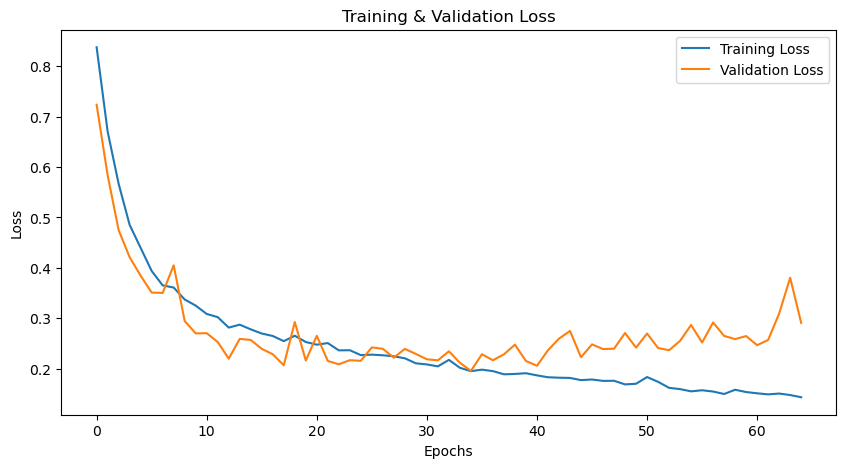

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52280 (\N{HANGUL SYLLABLE CAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/conda_cpu/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing fro

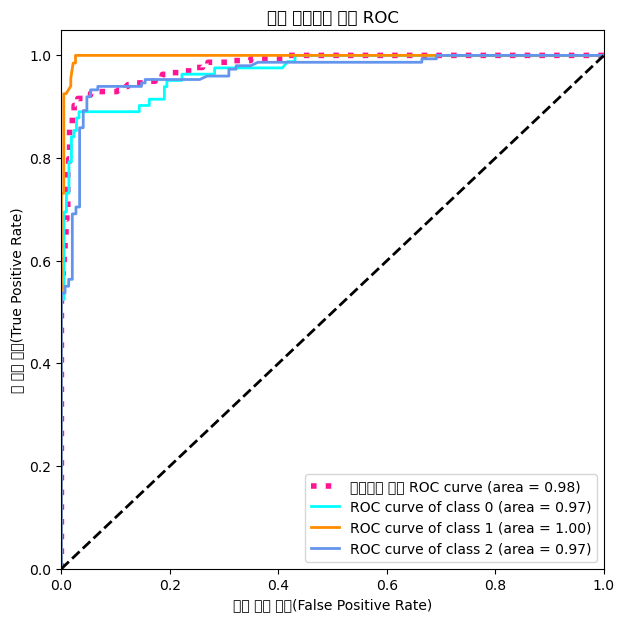

In [14]:
# ROC Curve 그리기 함수
def plot_multiclass_roc_curve(test_y, y_score, n_classes):
    # test_y를 이진화 (One-hot encoding)
    test_y_bin = label_binarize(test_y, classes=[*range(n_classes)])

    # 각 클래스에 대한 FPR, TPR, ROC AUC 계산
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 마이크로 평균 ROC 곡선 및 ROC 면적 계산
    fpr["micro"], tpr["micro"], _ = roc_curve(test_y_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # ROC 곡선 그리기
    plt.figure(figsize=(7, 7))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('(False Positive Rate)')
    plt.ylabel('(True Positive Rate)')
    plt.title('multi class ROC')
    plt.legend(loc="lower right")
    plt.show()

# 사용 예시
from sklearn.preprocessing import label_binarize

# test_y 예시: 실제 타겟 레이블
# y_score 예시: 모델이 예측한 확률
# n_classes: 클래스의 개수, 이 경우에는 3
y_score = model(test_x).detach().numpy()
plot_multiclass_roc_curve(test_y, y_score, n_classes=3)

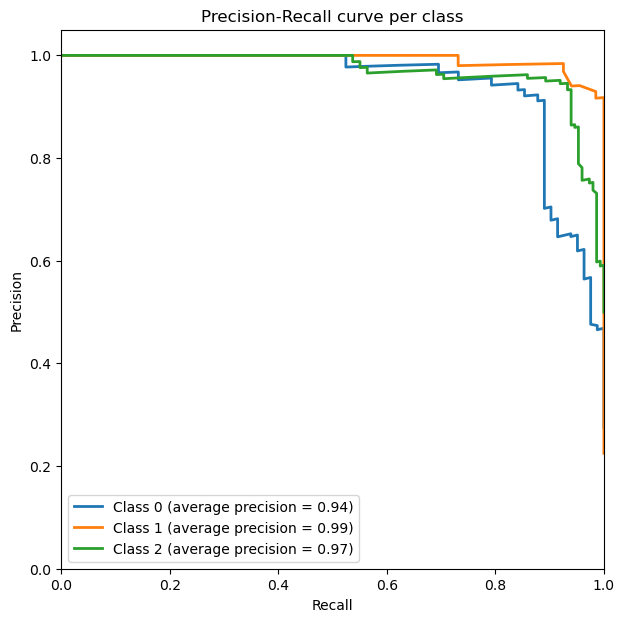

In [15]:
def plot_precision_recall_curve(test_y, y_score, n_classes):
    # test_y를 이진화
    test_y = label_binarize(test_y, classes=[*range(n_classes)])
    
    # 클래스별 Precision-Recall Curve와 평균 Precision을 계산하고 그립니다.
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(test_y[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(test_y[:, i], y_score[:, i])

    # 각 클래스에 대한 Precision-Recall Curve를 그립니다.
    plt.figure(figsize=(7, 7))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (average precision = {average_precision[i]:0.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve per class')
    plt.legend(loc="best")
    plt.show()
    
plot_precision_recall_curve(test_y, y_score, n_classes=3)

In [16]:
# 예측값 생성
y_pred = np.argmax(y_score, axis=1)
test_y_labels = np.argmax(test_y, axis=1)  # 실제 레이블

In [17]:
# 정확도
accuracy = accuracy_score(test_y_labels, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9161073825503355


In [18]:
# 혼동 행렬
conf_matrix = confusion_matrix(test_y_labels, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[ 69   1  12]
 [  0  62   5]
 [  6   1 142]]


In [19]:
with open("CNN LSTM confusion matrix.txt", "w") as text_file:
    print(confusion_matrix(test_y_labels, y_pred), file=text_file)

In [20]:
# 분류 보고서
class_report = classification_report(test_y_labels, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88        82
           1       0.97      0.93      0.95        67
           2       0.89      0.95      0.92       149

    accuracy                           0.92       298
   macro avg       0.93      0.91      0.92       298
weighted avg       0.92      0.92      0.92       298



In [21]:
with open("CNN-LSTM output.txt", "w") as text_file:
    print(classification_report(test_y_labels, y_pred,digits=4), file=text_file)